# Power Grid Network


### 1.1 Dataset


The following notebook studies Power Grid Network. This is *undirected, unweighted* network representing the topology of the Western States Power Grid of the United States. Each node is a power plant, transformer or consumer, and two nodes are connected if they are physically connected via a cable.


Data was compiled by D. Watts and S. Strogatz and made available on the web:  [Dataset Link](https://pubmed.ncbi.nlm.nih.gov/9623998/).

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv

In [2]:
G = nx.Graph()

with open("static/powergrid_edgelist.txt", "r") as file:
    f1 = csv.reader(file, delimiter='\t')
    for row in f1:
        node1, node2 = map(int, row)
        G.add_edge(node1, node2)

total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()

print(f'Number of nodes: {total_nodes}')
print(f'Number of edges: {total_edges}')

Number of nodes: 4941
Number of edges: 6594


The dataset contains **4941** nodes and **6594** edges.

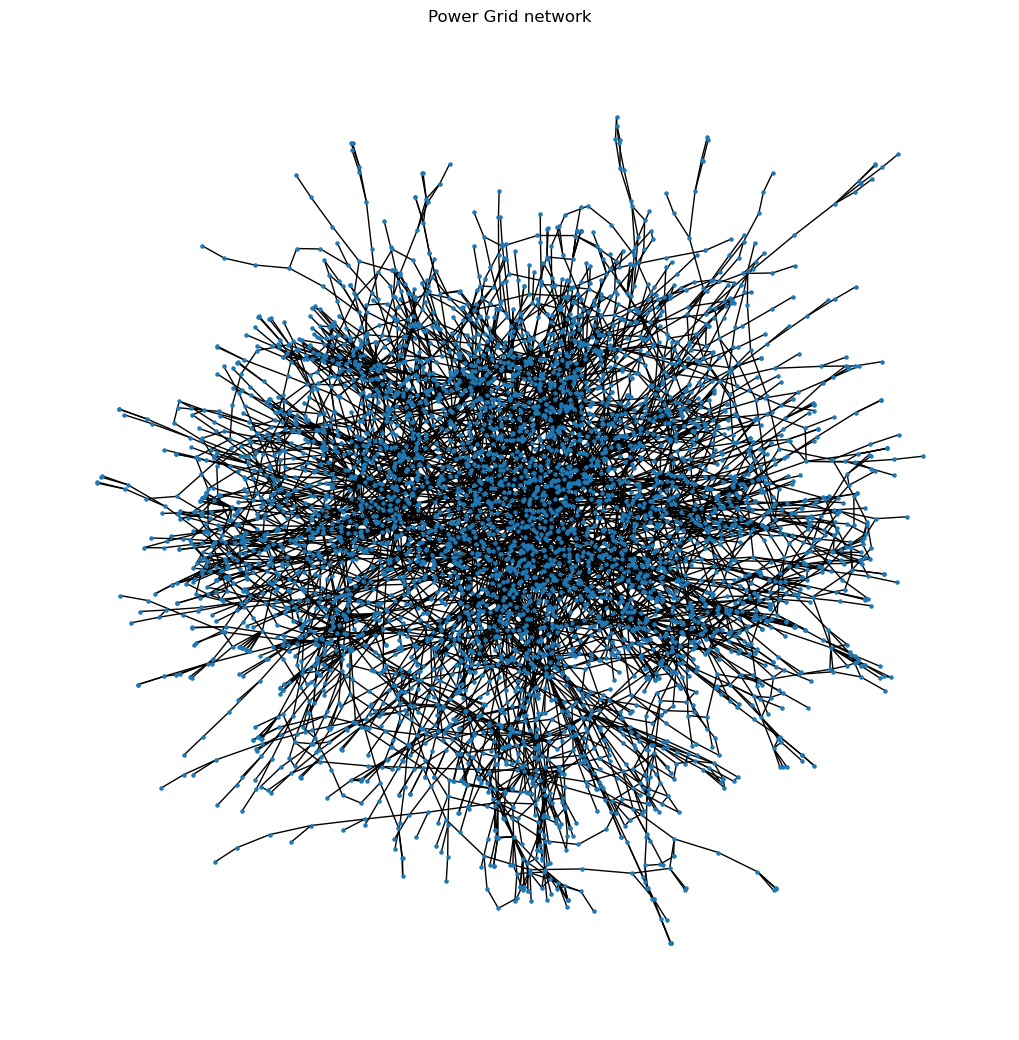

In [3]:
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=5)
plt.title("Power Grid network")
plt.show()

### 1.2 Network characterization

#### 1.2.1 Giant Component

In the context of a power grid network, the giant component represents a highly interconnected subset of electric infrastructure within the overall network topology.

In [4]:
giant_component = max(nx.connected_components(G), key=len)

G_giant = G.subgraph(giant_component)


giant_component_nodes = G_giant.number_of_nodes()
giant_component_edges = G_giant.number_of_edges()


giant_nodes_percentage = 100 * giant_component_nodes / total_nodes
giant_edges_percentage = 100 * giant_component_edges / total_edges

print(f'Number of nodes in the giant component: {giant_component_nodes} ({giant_nodes_percentage:.2f}% of all nodes)')
print(f'Number of edges in the giant component: {giant_component_edges} ({giant_edges_percentage:.2f}% of all edges)')

Number of nodes in the giant component: 4941 (100.00% of all nodes)
Number of edges in the giant component: 6594 (100.00% of all edges)


As we can see above every node and as a consequence every edge of the network belongs to the giant component. In this context, the conclusion is that the power grid network to ensure robustness and resilience against node failures or disruptions doesn't have any subgraphs and is centralized. 

#### 1.2.2 Network measures

To calculate these values I've used networkx functions.

In [5]:
# Average degree
average_degree = 2 * total_edges / total_nodes

# Average path length
average_path_length = nx.average_shortest_path_length(G)

# Diameter 
diameter = nx.approximation.diameter(G)

# Clustering Coefficient
clustering_coefficient = nx.average_clustering(G)




print(f'Average Degree: {average_degree:.2f}')
print(f'Average Path Length: {average_path_length:.2f}')
print(f'Diameter: {diameter}')
print(f'Clustering Coefficient: {clustering_coefficient:.2f}')

Average Degree: 2.67
Average Path Length: 18.99
Diameter: 46
Clustering Coefficient: 0.08


 **Average node degree of 2.67** suggest a moderate level of connectivity among electic infrastructure. It suggests a sufficient level of interconnection for the network's operations, as electrical failures don't happen that often, and 1 or 2 alternatives is enough in this context. This also reflects a less complex network structure compared to other types of networks. 

**Average Path Length of 18.99** and **diameter of 46** demonstrates that the Power Grid network has relatively longer distances between nodes. These values imply that data transmission or power distribution may experience higher latency or require more intermediate steps. This is perfectly reasonable, since entire West Coast is more than 2000 km long and connecting one northern point to one southern requires multiple intermediary nodes. This reflects the extensive geographical coverage of the power grid infrastructure.

**Clustering Coefficient of 0.08** exhibits a low level of clustering. This indicates that neighboring nodes in the network are not highly likely to be connected to each other. This is also an indicative of structural similarity of power grid network to a planar graph, where nodes are connected in such a way that graphs can be drawn on a plane without any edges crossing each other.

#### 1.2.3 Degree Distribution

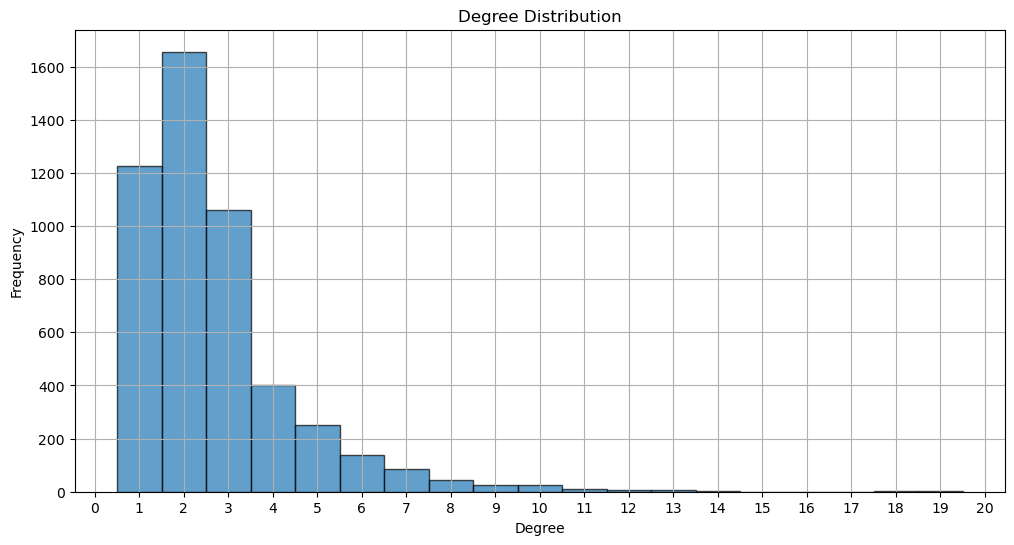

In [6]:
# Assuming G is your network
degree_sequence = [d for n, d in G.degree()]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(degree_sequence, bins=range(1, 21, 1), alpha=0.7, edgecolor='black', align='left')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.xticks(range(0, 21, 1))
plt.grid(True)
plt.show()

As we can see above most of the nodes have small degree - 1, 2 or 3 degree. Maximum degree is 19 with only one node.

In [7]:
specified_values = [x for x in range(20)]

hist, _ = np.histogram(degree_sequence, bins=range(0, 21, 1))

# Extract counts for the specified values
counts_for_specified_values = {value: hist[value] for value in specified_values}

del counts_for_specified_values[0]

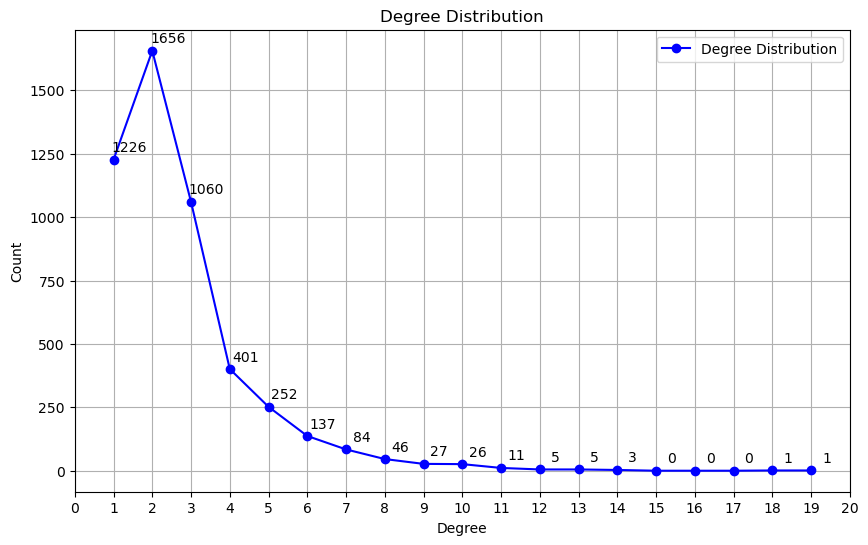

In [8]:
degrees = list(counts_for_specified_values.keys())
degree_counts = list(counts_for_specified_values.values())

fig = plt.figure(figsize=(10, 6))
plt.plot(degrees, degree_counts, 'bo-', label='Degree Distribution')
plt.xlabel('Degree')
plt.xticks(range(0, 21, 1))
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.grid(True)
plt.legend()

for degree, count in zip(degrees, degree_counts):
    plt.text(degree + 0.4, count + 20, str(count), ha='center', va='bottom')

# Save the plot as a variable
degree_distribution_plot = fig

plt.show()


In [9]:
from scipy.optimize import curve_fit

def func(x, a, k):
    return a * np.power(x, -k)

def get_power_law_curve(degrees, degree_counts):
    popt, pcov = curve_fit(func, degrees, degree_counts)

    # Extract optimized parameters
    a_opt, k_opt = popt

    # Generate the fitted curve
    fitted_curve = func(degrees, a_opt, k_opt)  

    return [fitted_curve, a_opt, k_opt]

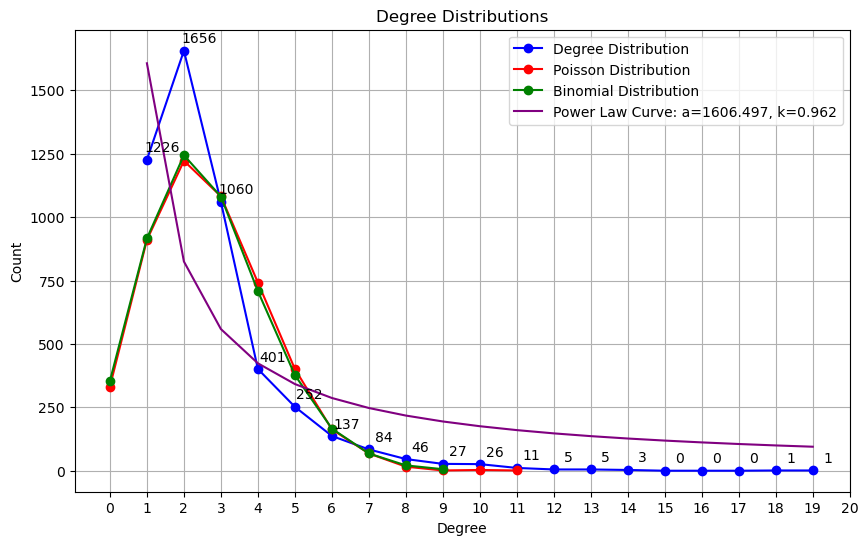

In [10]:
power_law_curve, a_opt, k_opt = get_power_law_curve(degrees, degree_counts)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Degree Distribution
ax.plot(degrees, degree_counts, 'bo-', label='Degree Distribution')

# Add count annotations
for degree, count in zip(degrees, degree_counts):
    ax.text(degree + 0.4, count + 20, str(count), ha='center', va='bottom')

# Generate Poisson and Binomial distributions
poisson = np.random.poisson(average_degree, total_nodes)
poisson_degree_sequence = sorted(poisson, reverse=True)
poisson_degreeCount = np.array(np.unique(poisson_degree_sequence, return_counts=True)).T
poisson_degreeCount = poisson_degreeCount[poisson_degreeCount[:, 0].argsort()]
poisson_degree, poisson_count = poisson_degreeCount.T

binomial = np.random.binomial(total_nodes, average_degree / total_nodes, total_nodes)
binomial_degree_sequence = sorted(binomial, reverse=True)
binomial_degreeCount = np.array(np.unique(binomial_degree_sequence, return_counts=True)).T
binomial_degreeCount = binomial_degreeCount[binomial_degreeCount[:, 0].argsort()]
binomial_degree, binomial_count = binomial_degreeCount.T

# Plot Poisson Distribution
ax.plot(poisson_degree, poisson_count, 'ro-', label='Poisson Distribution')

# Plot Binomial Distribution
ax.plot(binomial_degree, binomial_count, 'go-', label='Binomial Distribution')

# Plot Power Law Distribution
plt.plot(degrees, power_law_curve, color='purple', label='Power Law Curve: a=%5.3f, k=%5.3f' % (a_opt, k_opt))

# Set labels and title
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
plt.xticks(range(0, 21, 1))
ax.set_title('Degree Distributions')
ax.grid(True)
ax.legend()

plt.show()


To properly calculate Power Law curve there was a necessity to delete value 0 from the list. As we can see network degree distribution is not entirely similar to any of the degree distribution.

In [11]:
def mse(observed, expected):
    return np.mean((observed - expected)**2)

# Initialize arrays for Poisson and Binomial counts
max_degree = max(len(degree_counts), len(poisson_count), len(binomial_count))
poisson_count_full = np.zeros(max_degree)
binomial_count_full = np.zeros(max_degree)

# Update counts for degrees present in the Poisson distribution
for i, degree in enumerate(poisson_degree):
    poisson_count_full[degree] = poisson_count[i]

# Update counts for degrees present in the Binomial distribution
for i, degree in enumerate(binomial_degree):
    binomial_count_full[degree] = binomial_count[i]

# Calculate MSE for Poisson Distribution
mse_poisson = mse(degree_counts, poisson_count_full)

# Calculate MSE for Binomial Distribution
mse_binomial = mse(degree_counts, binomial_count_full)

# Calculate MSE for Power Law Distribution
mse_power_law = mse(degree_counts, power_law_curve)

print(f'Mean Squared Error (MSE) - Poisson: {mse_poisson:.2f}')
print(f'Mean Squared Error (MSE) - Binomial: {mse_binomial:.2f}')
print(f'Mean Squared Error (MSE) - Power Law: {mse_power_law:.2f}')


Mean Squared Error (MSE) - Poisson: 113849.47
Mean Squared Error (MSE) - Binomial: 109347.47
Mean Squared Error (MSE) - Power Law: 71350.07


This observation is confirmed by the above results. The mean square error is relatively high for all 3 distributions.

In [12]:
print(poisson_count_full)
print(binomial_count_full)
print(power_law_curve)

[3.320e+02 9.100e+02 1.222e+03 1.082e+03 7.420e+02 4.010e+02 1.630e+02
 6.800e+01 1.600e+01 1.000e+00 3.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[ 354.  916. 1244. 1081.  708.  377.  166.   68.   21.    6.    0.    0.
    0.    0.    0.    0.    0.    0.    0.]
[1606.49731002  824.87776746  558.53265255  423.54464399  341.7465192
  286.78614313  247.27356568  217.47472478  194.18564975  175.4743715
  160.10605066  147.25422321  136.34468495  126.96595602  118.81538094
  111.66533821  105.34131425   99.70724771   94.65547726]


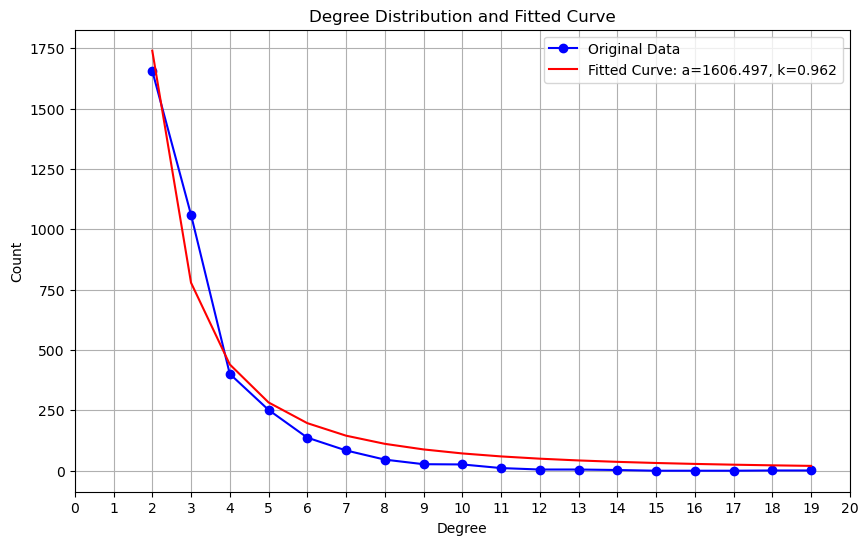

Optimized Parameters:
a = 1606.4973100186635
k = 0.9616663071151159
[1739.45584032  778.6514692   440.22407318  282.85674462  197.06227282
  145.17542912  111.4125637    88.21312085   71.58580595   59.26156528
   49.87281332   42.55533725   36.74121369   32.04473013   28.19645745
   25.00356906   22.32510793   20.05609498]
Mean Squared Error (MSE) - Adjusted Power Law: 6456.83


In [13]:
counts_copy = counts_for_specified_values
try:
    del(counts_copy[1])
except:
    print("Already deleted")

degrees_copy = list(counts_copy.keys())
degree_counts_copy = list(counts_copy.values())

power_law_curve_adjusted, copy_a_opt, copy_k_opt= get_power_law_curve(degrees_copy, degree_counts_copy)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(degrees_copy, degree_counts_copy, 'bo-', label='Original Data')
plt.plot(degrees_copy, power_law_curve_adjusted, 'r-', label='Fitted Curve: a=%5.3f, k=%5.3f' % (a_opt, k_opt))
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution and Fitted Curve')
plt.legend()
plt.xticks(range(0, 21, 1))
plt.grid(True)
plt.show()

print("Optimized Parameters:")
print("a =", a_opt)
print("k =", k_opt)

print(power_law_curve_adjusted)

mse_power_law = mse(degree_counts_copy, power_law_curve_adjusted)
print(f'Mean Squared Error (MSE) - Adjusted Power Law: {mse_power_law:.2f}')

However, when observing the graph, it can be seen that if it were not for the value for Degree=1 the correct distribution would almost coincide with the Power Law Curve. When this value is removed, MSE=6456.83, representing a more than 90% reduction in error. 

### 1.3 Centrality

#### 1.3.1 Calculate the measures: degree, closeness, betweenness, pagerank

To calculate these values I've used networkx functions and saved the result in the dataframe **centrality_df**.

In [14]:
# # Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calculate PageRank
pagerank = nx.pagerank(G)

# Dataframe will all the values
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree': list(degree_centrality.values()),
    'Closeness': list(closeness_centrality.values()),
    'Betweenness': list(betweenness_centrality.values()),
    'PageRank': list(pagerank.values())
})

centrality_df.set_index('Node', inplace=True)

centrality_df

,Degree,Closeness,Betweenness,PageRank
Node,,,,
0,0.000607,0.066088,0.002515,0.000211
386,0.001215,0.063652,0.001307,0.000445
395,0.001012,0.070713,0.037108,0.000318
451,0.000607,0.062035,0.001180,0.000232
1,0.000810,0.045759,0.005204,0.000296
...,...,...,...,...
4932,0.000405,0.047177,0.002023,0.000185
4935,0.000405,0.045055,0.001618,0.000201
4933,0.000405,0.047177,0.000357,0.000180


#### 1.3.2 Identificate the most relevant nodes and explains their relevance for the network

To achieve that I created first a dataframe with normalized values in the range from 1 to 10. 

In [15]:
columns_to_normalize = ['Degree', 'Closeness', 'Betweenness', 'PageRank']

# Normalize the specified columns
min_val = 1
max_val = 10
centrality_df_normalized = centrality_df.copy()
for column in columns_to_normalize:
    centrality_df_normalized[column] = min_val + (centrality_df_normalized[column] - centrality_df_normalized[column].min()) * (max_val - min_val) / (centrality_df_normalized[column].max() - centrality_df_normalized[column].min())

centrality_df_normalized

,Degree,Closeness,Betweenness,PageRank
Node,,,,
0,2.0,7.077296,1.078490,2.165161
386,3.5,6.624788,1.040772,3.989099
395,3.0,7.936346,2.157965,2.994409
451,2.0,6.324589,1.036814,2.327746
1,2.5,3.301332,1.162388,2.823402
...,...,...,...,...
4932,1.5,3.564718,1.063117,1.961720
4935,1.5,3.170640,1.050504,2.081690
4933,1.5,3.564885,1.011135,1.918642


To extract the most important nodes, I've calculated geometric average of 4 normalized columns and sorted obtained dataframe. 

In [16]:
centrality_df_normalized['Geometric_Average'] = np.power(centrality_df_normalized['Degree'] * centrality_df_normalized['Closeness'] * centrality_df_normalized['Betweenness'] * centrality_df_normalized['PageRank'], 1/4)

top_10_nodes_normalized = centrality_df_normalized.sort_values(by='Geometric_Average', ascending=False).head(10)

avg_geometric_average = centrality_df_normalized['Geometric_Average'].mean()
median_geometric_average = centrality_df_normalized['Geometric_Average'].median()

print(f'Average geometric average in the dataset: {avg_geometric_average:.2f}')
print(f'Median geometric average in the dataset: {median_geometric_average:.2f}')

top_10_indexes = top_10_nodes_normalized.index

top_10_nodes = centrality_df.loc[top_10_indexes]


top_10_nodes_normalized


Average geometric average in the dataset: 2.07
Median geometric average in the dataset: 1.95


,Degree,Closeness,Betweenness,PageRank,Geometric_Average
Node,,,,,
4458,9.5,7.348022,2.428918,10.000000,6.416922
4164,4.0,9.074054,10.000000,3.721882,6.062559
1243,3.5,9.536308,9.727879,3.287727,5.715978
2543,3.5,9.294742,9.790381,3.327353,5.705595
2606,4.0,9.591882,7.338236,3.654416,5.663611
2528,3.5,9.433401,9.341227,3.257390,5.629924
69,4.0,8.113745,6.745565,4.138782,5.486471
2235,4.5,8.467019,5.794771,4.102749,5.486098
1267,3.5,9.068285,8.747289,3.257673,5.483951


In [17]:
top_10_nodes

,Degree,Closeness,Betweenness,PageRank
Node,,,,
4458,0.003644,0.067545,0.045791,0.001215
4164,0.001417,0.076838,0.288416,0.000411
1243,0.001215,0.079327,0.279695,0.000355
2543,0.001215,0.078026,0.281698,0.000360
2606,0.001417,0.079626,0.203116,0.000402
2528,0.001215,0.078773,0.267304,0.000351
69,0.001417,0.071668,0.184123,0.000464
2235,0.001619,0.073570,0.153654,0.000460
1267,0.001215,0.076807,0.248271,0.000351


As we can see above, the average geometric average across all nodes is relatively low - 2.07. Meanwhile, the median is even lower, at 1.95. These figures suggest that the majority of nodes have limited relevance within the overall network, often connecting to just 1, 2, or 3 other nodes. This scenario is typical in power grid networks, where electricity must reach even the most remote areas along the West Coast.

The top 10 nodes identified by the proposed metric exhibit geometric average values ranging from 5.468858 to 6.416922. While these values aren't exceptionally high, they do indicate significant importance within the network. 

Node 4458, the highest-ranked node, has a very high Degree Centrality value of 0.003644 or 9.5 in normalized version (equivalent to 18 edges out of a maximum of 19) and the highest Page Rank of 0.001215. This means that Node 4458 is connected to a lot crucial electric infrastructure. With Closeness scored at 0.067545 (normalized to 7.348022), this node is located close to the middle of the network. The only stand-off value is Betweenness scored at 0.045791 (normalized to only 2.428918). Although this node is connected to some crucial infrastrure of the network, the shortest paths do not pass through this point. In this context, we can conlude that this node is some big power plant, probably well connected to the main electricy path, but not directly on it. 

Next 3 nodes - 4164, 1243, 2543 and node 1267 (the 9th most important node) have relatively small Degree Centrality (normalized 3.5 corresponding to 6 edges, or 4.0, corresponding to 7 edges) and Pagenk. However their Closeness and Betweenness values are way above 9 in normalized version of the dataframe. These nodes are located on the main electricty path, right in the middle of it. Probably the path that connects nodes located on the north to those located on the south the best. In fact as we can see on the dataframe below pairs 1267 and 1243 are neighbors and 2543 is neighbor to other nodes in the Top 10 list - that is 2528. This node is also neighbor to node 2606, also being on the list.

In [18]:
connection_data = []

for edge in G.edges():
    node1, node2 = edge
    if node1 in top_10_indexes and node2 in top_10_indexes:
        connection_data.append({'Node 1': node1, 'Node 2': node2, 'Connected': True})

connection_table = pd.DataFrame(connection_data)

connection_table

,Node 1,Node 2,Connected
0,2543,2528,True
1,1267,1243,True
2,2528,2606,True


Below we can observe 10 worst nodes according to proposed metric.

In [19]:
worst_10_nodes = centrality_df_normalized.sort_values(by='Geometric_Average', ascending=True).head(10)

worst_10_nodes

,Degree,Closeness,Betweenness,PageRank,Geometric_Average
Node,,,,,
4379,1.0,1.000126,1.0,1.109040,1.026244
4350,1.0,1.000000,1.0,1.150367,1.035641
4388,1.0,1.213773,1.0,1.052663,1.063180
4394,1.0,1.438737,1.0,1.076072,1.115464
4393,1.0,1.682588,1.0,1.019971,1.144568
4338,1.0,1.682279,1.0,1.033876,1.148396
4390,1.0,1.682124,1.0,1.050797,1.153039
4389,1.0,1.682124,1.0,1.050797,1.153039
4339,1.0,1.681969,1.0,1.058679,1.155169


### 1.4 Comparison with a random network and small-world phenomena

Justify the significance of the results comparing with a random network
Justify if exists a small-world phenomena

In [20]:
import math

try:
    random_network = nx.gnm_random_graph(total_nodes, total_edges)
    if not nx.is_connected(random_network):
        # Get the largest connected component
        largest_component = max(nx.connected_components(random_network), key=len)
        random_network = random_network.subgraph(largest_component).copy()
except nx.NetworkXError:
    print("The random network creation failed.")


try:
    average_shortest_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    clustering_coefficient = nx.average_clustering(G)

    average_degree = sum(dict(G.degree()).values()) / len(G.nodes())
    log_N_over_log_k = math.log(len(G.nodes())) / math.log(average_degree)
except nx.NetworkXError:
    print("The metrics calculation for your network failed.")


try:
    average_shortest_path_random = nx.average_shortest_path_length(random_network)
    diameter_random = nx.diameter(random_network)
    clustering_coefficient_random = nx.average_clustering(random_network)

    average_degree = sum(dict(random_network.degree()).values()) / len(random_network.nodes())
    log_N_over_log_k_random = math.log(len(random_network.nodes())) / math.log(average_degree)
except nx.NetworkXError:
    print("The metrics calculation for the random network failed.")




data = {
    'Metric': ['Average Shortest Path', 'Diameter', 'Clustering Coefficient', 'Log(N)/Log(k)'],
    'Power Grid Network': [average_shortest_path, diameter, clustering_coefficient, log_N_over_log_k],
    'Random Network': [average_shortest_path_random, diameter_random, clustering_coefficient_random, log_N_over_log_k_random]
}

metrics_df = pd.DataFrame(data)


In [21]:
metrics_df

,Metric,Power Grid Network,Random Network
0,Average Shortest Path,18.989185,8.401933
1,Diameter,46.000000,19.000000
2,Clustering Coefficient,0.080104,0.000645
3,Log(N)/Log(k),8.663523,7.844615


Comparing the average shortest path and diameter of the Power Grid Network to those of the random network reveals significantly higher values. In this regard, the analyzed network does not meet the criteria for a small-world network, as the small-world effect implies short paths.

Additionally, the clustering coefficient in the Power Grid Network is notably higher than in the Random Network. However, these values remain relatively low, likely due to the limited number of edges compared to the number of nodes. Thus, while the clustering coefficient is higher in the Power Grid Network, it does not sufficiently meet the requirements for the small-world effect, which implies a high clustering coefficient.

Furthermore, the Log(N)/Log(k) score for both networks is relatively high, with the Power Grid Network scoring 8.66 and the Random Network scoring 7.85. This suggests that both networks exhibit characteristics of scale-free networks, where the number of nodes increases logarithmically with respect to the number of edges.

In summary, while the Power Grid Network demonstrates some clustering behavior and scale-free characteristics, its longer average shortest paths and diameter indicate that it does not conform to the small-world phenomenon, which is characterized by both short paths and high clustering.